In [1]:
%matplotlib inline

In [2]:
import os
import random

In [3]:
import keras
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
import matplotlib.patches as mpatches
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [4]:
seed = 7
random.seed(seed)
np.random.seed(seed)

In [5]:
base_dir = r'C:\Users\Home\Documents\PyCharm Projects\KerasTwo'
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

<h3> Data Preprocessing Function </h3>

In [6]:
def get_data(folder_path="", img_class=""):
    files = os.listdir(folder_path)

    final_data = []
    final_labels = []

    for mfile in files:
        file_path = os.path.abspath(os.path.join(folder_path, mfile))
        file_data = np.array(cv.imread(file_path, cv.IMREAD_GRAYSCALE))
        file_data = file_data.reshape(64, 64, 1)
        final_data.append(file_data)

        if img_class == "cat":
            file_label = np.array([0])
        if img_class == "dog":
            file_label = np.array([1])

        final_labels.append(file_label)

    final_data = np.array(final_data)
    final_labels = np.array(final_labels)

    return final_data, final_labels

<h4> Retreiving Data From Folders  </h4>

In [7]:
cat_d, cat_l = get_data(cat_dir, "cat")
dog_d, dog_l = get_data(dog_dir, "dog")

final_d = np.concatenate([cat_d, dog_d])
final_l = np.concatenate([cat_l, dog_l])

# zip and shuffle
final = list(zip(final_d, final_l))
random.shuffle(final)

# unzip
final_d, final_l = zip(*final)

final_l = np.array(final_l)
final_d = np.array(final_d)

In [8]:
kfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=seed)
cross_data = kfold.split(final_d, final_l)
train, test = next(cross_data)

<h4> Testing Labels </h4>

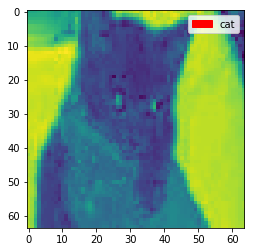

In [15]:
    img_label = final_l[1000]
    img_data = final_d[1000]
    b = (img_label == [1])
    val = "dog" if b else "cat"
    img_data = img_data.reshape(64,64)
    red_patch = mpatches.Patch(color='red' if val == "cat" else 'black', label=val)
    plt.legend(handles=[red_patch])
    plt.imshow(img_data, label=val)
    plt.show()

<h2> Keras Modeling </h2>

In [10]:
# parameters
batch_size = 48
#num_classes = 2
epochs = 14

# input dimensions
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

In [11]:
model = Sequential()
model.add(Conv2D(kernel_size=(3, 3), filters=6, input_shape=input_shape, activation="relu", padding="valid"))
model.add(Conv2D(kernel_size=(3, 3), filters=10, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(kernel_size=(3, 3), filters=12, activation="relu", padding="same"))
model.add(Conv2D(kernel_size=(5, 5), filters=12, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(kernel_size=(2, 2), strides=(2, 2), filters=20))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 6)         60        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 10)        550       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 12)        1092      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 12)        3612      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 20)          980       
__________

In [12]:
tb_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(final_d[train], final_l[train],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, shuffle=True, validation_data=(final_d[test], final_l[test]))

Train on 23332 samples, validate on 1668 samples
Epoch 1/14
23332/23332 [==============================] - 431s 18ms/step - loss: 0.6316 - acc: 0.6381 - val_loss: 0.5861 - val_acc: 0.6882
Epoch 2/14
23332/23332 [==============================] - 305s 13ms/step - loss: 0.5483 - acc: 0.7196 - val_loss: 0.5414 - val_acc: 0.7206
Epoch 3/14
23332/23332 [==============================] - 304s 13ms/step - loss: 0.5103 - acc: 0.7436 - val_loss: 0.5562 - val_acc: 0.7104
Epoch 4/14
23332/23332 [==============================] - 309s 13ms/step - loss: 0.4833 - acc: 0.7652 - val_loss: 0.5208 - val_acc: 0.7368
Epoch 5/14
23332/23332 [==============================] - 309s 13ms/step - loss: 0.4584 - acc: 0.7815 - val_loss: 0.5591 - val_acc: 0.7302
Epoch 6/14
23332/23332 [==============================] - 309s 13ms/step - loss: 0.4358 - acc: 0.7942 - val_loss: 0.5144 - val_acc: 0.7422
Epoch 7/14
23332/23332 [==============================] - 309s 13ms/step - loss: 0.4161 - acc: 0.8057 - val_loss: 0.4

In [13]:
score = model.evaluate(final_d[test], final_l[test], verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1668/1668 [==============================] - 8s 5ms/step
Test loss: 0.5420979576573955
Test accuracy: 0.7583932853717026


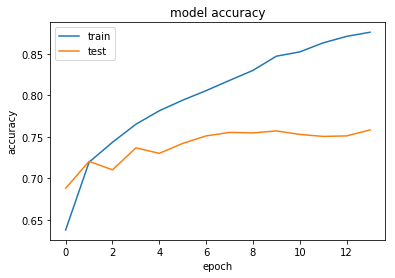

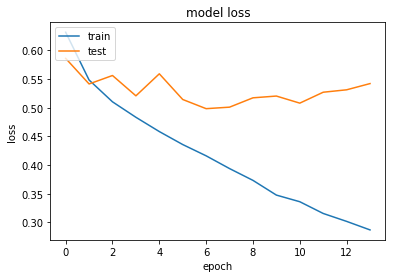

In [14]:
# summarizing accuracy/epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize loss/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


<h1>Final Results</h1>

<h3>Accuracy: 76%</h3>
<h3>Epochs: 14</h3>